# Predictive and Manual Classification

## Jay Sahaym

14 August 2022

Introduction to Computational Literary Analysis

Department of Digital Humanities, University of California, Berkeley

Instructor: Jonathan Reeve

Genre is a foundational concept in literature. Books, as cultural products, are grouped based on similarities observed by the consumer (Piters and Stokmans). Genres function as categories for works of literature, allowing for comparison and classification. The grouping allows for more coherence for both readers and authors. However, the most important function they serve is familiarity. Genres establish convention; plots and subplots develop in conventional ways and characters react to these developments similarly across works in the genre. There are three main ways in which these categories are represented: form, style, and content.

Form is probably the simplest of the three to understand. Literature is written and presented in many different ways, which are called forms. Broad examples of these forms include novels, short stories, poems, and plays, though there are of course many more subcategories. Form is useful in establishing corpora in computational literary analysis because it ensures that works have similar amounts of content to analyze, easily verifiable with a function to check the word count. Additionally, the author’s choice of form can provide sections of the text which add a comparative element to any analysis.
Style and content present a different set of challenges, especially when looking through the lens of genre. Genre fundamentally deals with content, the plot, message, and themes in the text. Genres, as a representation of conventionality, are tied to content. Works written in different forms can be classified together because of the content. Style presents more challenges computationally. Though sentence and word tokenizers have advanced to the point where computational analysis can be quite sophisticated, the correct application of these techniques to determine style becomes the challenge.

These three dimensions of a work are intertwined when it comes to defining the genre of a work. Some works, namely those classified under literary fiction, are generally considered to be beyond the boundaries of genre fiction. Some academics have suggested that the difference is because of “relative degrees of uncritical reliance on widely shared scripts, schemas, and stereotypes” (Kidd and Castano, 475). However, all fictional works will have a plot of some sort. The novels of Jane Austen, for example, are widely considered to be some of the finest novels ever written, and therefore literary fiction. However, as a reader, it would be impossible to not classify works such as *Pride and Prejudice* and *Sense and Sensibility* as romance novels. This project will seek to explore how predictive classification of style and genre differ from a close reading perspective.

In [218]:
# Add all your import statements in this cell
import os
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.draw import dispersion_plot
from nltk.corpus import stopwords
from collections import Counter
import string 
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from nltk.corpus import brown
from sklearn.decomposition import LatentDirichletAllocation

In [219]:
stop_words = set(stopwords.words('english'))

## Establishing Corpora

For my analysis, I will be using two collections of short stories, *The Garden Party and Other Stories* by Katherine Mansfield, written in 1922, and *Dubliners* by James Joyce, written in 1914. Stories from both of these collections were read in class. Additionally, using these two collections restricts several factors that may affect the analysis. The forms of the corpora are similar, with fourteen stories written by Mansfield and 15 written by Joyce. Furthermore, the authors are from the same literary era and are considered to be some of the most influential modernist writers.

 I have cleaned the strings to make processing easier. To do so, I used a manually created list of characters that I wanted to replace. I then looped through each string. I also removed stopwords to emphasize the plot elements that are created with the style. While stopwords can add to the analysis of style, for my research it was unnecessary to look at the precise construction of the narrative and associated genre. Instead, I held the style of the actual content to be more important.

In [230]:
dubliners = open(r"C:\Users\Jay Sahaym\DH150C\Readings\content\texts\dubliners.md", encoding = "utf-8").read()
def clean(text):
    toReplace = ["\xa0", "…", "–", "—", "\n"]
    for char in toReplace:
        text = text.replace(char, ' ')
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    ' '.join(text)
clean(dubliners)
storyList = ['The Sisters',
'An encounter',
'Araby',
'Eveline',
'After the race',
'Two gallants',
'The boarding house',
'A little cloud',
'Counterparts',
'Clay',
'A painful case',
'Ivy Day in the Committee Room',
'A mother',
'Grace',
'The Dead.']
dublinersList = dubliners.split("##")
del dublinersList[0]
dubCorpus = dict(zip(storyList, dublinersList))
dubCorpus['author'] = 'Joyce'
#del dubCorpus['After the race'],dubCorpus['Two gallants'], dubCorpus['A little cloud'], dubCorpus['Counterparts'], dubCorpus['A painful case']

In [231]:
garden = open(r"C:\Users\Jay Sahaym\DH150C\Readings\content\texts\garden-party.md", encoding="utf-8").read()

clean(garden)
    
gardenBoundaries = {"At the Bay": ("# At the Bay", "# The Garden Party"),
                    "The Garden Party": ("# The Garden Party", "# The Daughters of the Late Colonel"),
                    "The Daughters of the Late Colonel": ("# The Daughters of the Late Colonel", "# Mr. and Mrs. Dove"),
                    'Mr. and Mrs. Dove': ('# Mr. and Mrs. Dove','# The Young Girl'),
                    "The Young Girl": ("# The Young Girl", "# Life of Ma Parker"),
                    'Life of Ma Parker': ('# Life of Ma Parker','# Marriage a la Mode'),
                    "Marriage a la Mode": ("# Marriage a la Mode", "# The Voyage"),
                    'The Voyage': ('# The Voyage','# Miss Brill'),
                    'Miss Brill': ('# Miss Brill','# Her First Ball'),
                    "Her First Ball": ("# Her First Ball", "# The Singing Lesson"),
                    'The Singing Lesson': ("# The Singing Lesson",'# The Stranger'),
                    'The Stranger': ('# The Stranger','# Bank Holiday'),
                    'Bank Holiday': ('# Bank Holiday','# An Ideal Family'),
                    "An Ideal Family": ("# An Ideal Family", "# The Lady's Maid")}

gardenCorpus = {'author': 'Mansfield'}
for story in gardenBoundaries:
    start = garden.index(gardenBoundaries[story][0])
    end = garden.index(gardenBoundaries[story][1])
    gardenCorpus[story] = garden[start:end]



In [232]:
combined = gardenCorpus | dubCorpus
combined['author'] = 'combined'

I am using the Brown Corpus as my comparative data set. The Brown Corpus is already divided into genres, which will help to show evidence that style, content, and genre are all intertwined.

In [223]:
brownGenres = {}
for genre in brown.categories():
    brownGenres[genre] = " ".join(brown.words(categories=genre))

## The Classifier

The following cell contains the function that I have constructed to build my genre predictor. The initial input for the function first takes the dictionary that we have constructed with the corpus and transfers the author to another variable to avoid an unnecessary category on the stylometric plot. The next section of the function utilizes term frequency–inverse document frequency to gather the most important words across the corpus. I use the TfidfVectorizer to transform the corpora into a sparse and then a dense matrix. I have set the `max_features` setting to 400 to limit the words that are being used in the matrix. I have set `use_idf` to True to emphasize the unique words in each work. The unique words are part of the distinguishing style of each work, so I decided to include the inverse document frequency.

The next part of the function uses Principal Component Analysis for stylometry. I have set the number of components to two for simplicity within the data frames I am using. The stylometry plot has blue points for the Brown Corpus, which is the baseline for the comparisons. The red points on the graphs are what I am actually observing. To generate the predictions, I compare the red points on the graph with each blue point representing a Brown genre. The x- and y-distances are calculated, and the shortest distance is then assumed to be the genre of the short story.

In [233]:
def genrePredictor(corpus):
    if 'author' in corpus.keys():
        author = corpus["author"]
        del corpus["author"] # prevent author from showing up in graph
    
    tfidfVectorizer = TfidfVectorizer(min_df=1, max_features=400, use_idf=True)
    brownFreq = tfidfVectorizer.fit_transform(list(brownGenres.values())).todense()
    corpusFreq = tfidfVectorizer.fit_transform(list(corpus.values())).todense()

    pca = sklearn.decomposition.PCA(n_components=2)
    brownReduced=pca.fit_transform(brownFreq)
    corpusReduced=pca.fit_transform(corpusFreq)

    brown_df = pd.DataFrame(brownReduced, columns=['First Component', 'Second Component'], index=list(brownGenres.keys()))
    corpus_df = pd.DataFrame(corpusReduced, columns=['First Component', 'Second Component'], index=list(corpus.keys()))
    vertical_stack = pd.concat([corpus_df, brown_df], axis=0)
    ax = vertical_stack.plot(kind='scatter', x="First Component", y="Second Component",figsize=(8,8), c = list('r'*len(corpus)+'b'*len(brownGenres)),title = f'{author} Brown stylometry')
    for title,points in vertical_stack.iterrows():
        ax.annotate(title,points,fontsize=7,rotation=0)
    
    corpusGenres = {}
    for story in corpus:
        closest_dist = np.inf
        xcorpus, ycorpus = corpus_df.loc[story]
        for genre in brownGenres:
            xbrown, ybrown = brown_df.loc[genre]
            dist = ((ycorpus - ybrown) ** 2 + (xcorpus - xbrown) ** 2) ** 1/2
            if dist < closest_dist:
                closest = genre
                closest_dist = dist

        corpusGenres[story] = closest
    print(corpusGenres)
    return ax

## Results

Here I am using the function on three different corpora. The corpora used are *The Garden Party and Other Stories*, *Dubliners*, and a combination of the two. I decided to also use the combination because I wanted to see how the function would handle the new comparison. With a larger body of text, the TFIDF mechanism could handle the term distribution differently. The Brown Corpus obviously would not change since it is still being transformed and put into a data frame separately. However, the combination of *The Garden Party* and *Dubliners* ultimately did result in some changes in the position of certain stories on the PCA graph. The general trend I observed was that the Joyce stories moved negatively on both the horizontal and vertical axes, whereas the Mansfield stories did the opposite. The movement shows a clear stylistic difference between Joyce and Mansfield, even though they are both considered part of the modernist tradition.

There are several other results worth noting in this section. Firstly, there are clear style clusters amongst the Brown Corpus. Editorial, lore, reviews, government, and belles lettres form one. Another one is hobbies and religion. Spread out more are adventure and fiction, mystery, romance, and science fiction.

Another unexpected result is that the stories do not match the Brown Corpus particularly well. I anticipated that the Brown Corpus would be fairly spread out, with clusters of short stories around specific genres. However, the stories are quite scattered themselves. There are groups of short stories with similar styles but they do not seem to cluster around the genres from the Brown Corpus. This result implies that style and genre may not be as interconnected as I initially hypothesized.

C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


{'At the Bay': 'belles_lettres', 'The Garden Party': 'lore', 'The Daughters of the Late Colonel': 'romance', 'Mr. and Mrs. Dove': 'humor', 'The Young Girl': 'fiction', 'Life of Ma Parker': 'belles_lettres', 'Marriage a la Mode': 'hobbies', 'The Voyage': 'news', 'Miss Brill': 'news', 'Her First Ball': 'lore', 'The Singing Lesson': 'news', 'The Stranger': 'hobbies', 'Bank Holiday': 'government', 'An Ideal Family': 'hobbies'}


C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


{'The Sisters': 'belles_lettres', 'An encounter': 'hobbies', 'Araby': 'humor', 'Eveline': 'mystery', 'After the race': 'hobbies', 'Two gallants': 'hobbies', 'The boarding house': 'science_fiction', 'A little cloud': 'hobbies', 'Counterparts': 'religion', 'Clay': 'mystery', 'A painful case': 'humor', 'Ivy Day in the Committee Room': 'learned', 'A mother': 'adventure', 'Grace': 'news', 'The Dead.': 'humor'}
{'At the Bay': 'humor', 'The Garden Party': 'fiction', 'The Daughters of the Late Colonel': 'adventure', 'Mr. and Mrs. Dove': 'science_fiction', 'The Young Girl': 'romance', 'Life of Ma Parker': 'science_fiction', 'Marriage a la Mode': 'news', 'The Voyage': 'adventure', 'Miss Brill': 'romance', 'Her First Ball': 'science_fiction', 'The Singing Lesson': 'science_fiction', 'The Stranger': 'belles_lettres', 'Bank Holiday': 'hobbies', 'An Ideal Family': 'lore', 'The Sisters': 'reviews', 'An encounter': 'government', 'Araby': 'hobbies', 'Eveline': 'romance', 'After the race': 'government',

C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


<AxesSubplot:title={'center':'combined Brown stylometry'}, xlabel='First Component', ylabel='Second Component'>

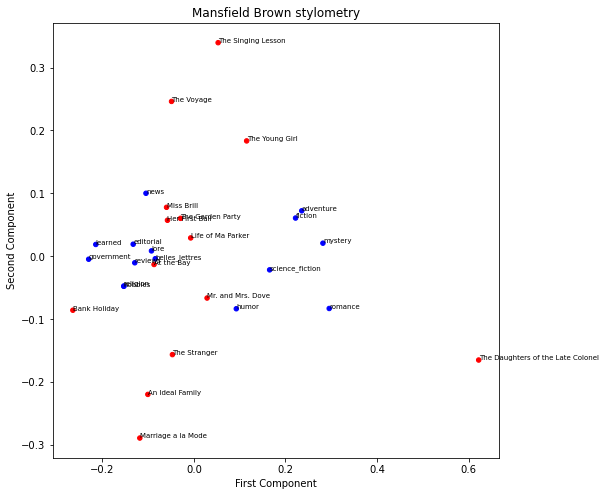

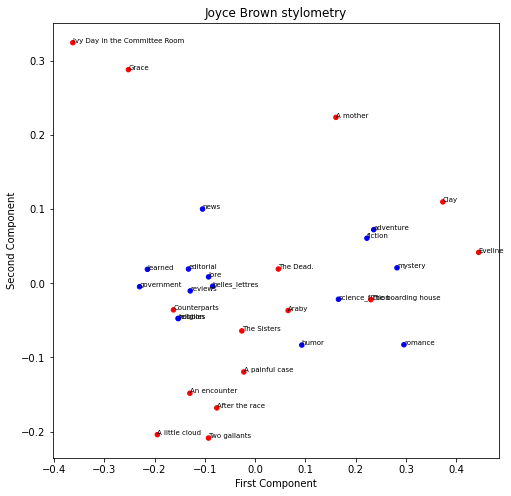

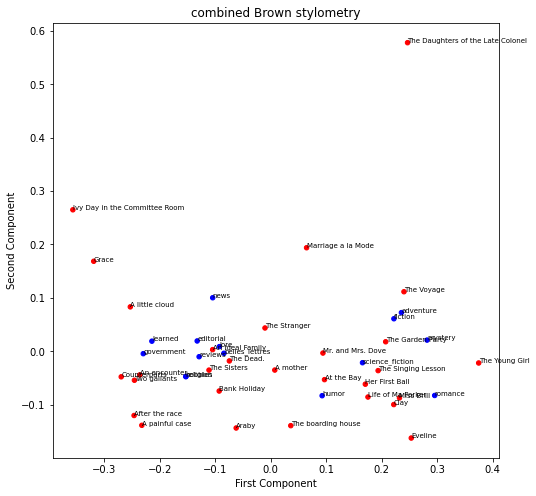

In [234]:
# subfigures
genrePredictor(gardenCorpus)
genrePredictor(dubCorpus)
genrePredictor(combined)

The accuracy of this model is also somewhat suspect based on this data. A major error can be seen with the classification of "Her First Ball" in the final combined results. In the initial Mansfield plot, it is listed as lore, whereas in the final results it is listed as science fiction. Neither of these classifications are accurate at all to any reader who has even glanced at the story.

There are other flaws with the model that are more subtle. The story "Clay" by James Joyce is a good example of these flaws in the computational process. Many of Joyce's stories deal with the element of paralysis, or not being able to move forward in life. He tracks these feelings through several characters in his portrayal of Dublin, whether physical like in "Eveline" or mental as he shows in "Clay." A major element of the romance genre is a change in the position of the character. However, in "Clay", the central figure, Maria, does not change at all. Instead, Joyce merely tracks her through her journey and her day. In fact, I would argue that "Clay" actually shows the opposite of romance. The only element of romance in Maria's life is the interaction with the gentleman on the train. Without that interaction, her life is dull and unfulfilling. The symbol of clay, the early death, has already taken place for Maria. She is left with no suitors and cannot even mention the possibility of such things in "I Dreamt that I Dwelt" as she skips the second verse. The events and the symbol emphasize that she has no romance in her life. These signifiers eliminate the possibility of "Clay" being a romance, despite the use of words like "wedding," "children," and "family." The model cannot judge in what context the words it collects are used in. All of the elements of a novel in the romance genre are mentioned repeatedly in "Clay", not as an indicator of the genre but as a subversion. Maria does not have any of the conventional elements in the romance genre.

A similar problem can be seen in the analysis of "Marriage a la Mode," one of Mansfield's stories. In the only Mansfield model, it is listed as hobbies and in the full corpus analysis, it is listed as news. The "hobbies" classification is the more relevant one as it conflicts the most with my interpretation of the story. The mention of toys and the activities that Isabel does with her friends is again misleading the model. The reason why Mansfield included those terms is to show how William is excluded from the activities that his "new" wife does. There is hardly any text that directly addresses any of the activities, though. The story mainly uses dialogue to show William's alienation, such as the line "God forbid, my darling, that I should be a drag on your happiness." In this sense, the story is similar to "Clay" in that it tracks the failure of each of the respective central characters.

Short stories are difficult to classify into specific genres, and the model reflects this. With less time to develop a full plot, the conventional character reactions to plot events and tropes that are critical to the very formation of the genre have fewer words dedicated to them. The model is then forced into a decision based on the limited dimensionality of the number of components used in the PCA. I would classify both "Clay" and "Marriage a la Mode" as character studies, not romance or hobbies. The intent behind each work is to allow the reader to observe the life of Maria and William and Isabel respectively, not to develop any specific type of plot. This literary style is difficult for a computer to recognize while in the process of distant reading. The model could perhaps be improved with a greater number of genres and subgenres. While the Brown Corpus is established and nicely divided into genres, subgenres would allow for more data for the model to access and refine.


In [226]:
humor = open(r"C:\Users\Jay Sahaym\DH150C\Readings\content\texts\americanhumor.txt", encoding = 'utf-8').read()
clean(humor)
americanmodern = humor[humor.find('It had been a day of triumph for Colonel Starbottle'):humor.find('*** END')]
humorBoundaries = {"COL. STARBOTTLE": ("It had been a day of triumph", "THE DUPLICITY"),
                    "THE DUPLICITY": ("THE DUPLICITY", "BARGAIN DAY AT TUTT HOUSE"),
                    "BARGAIN DAY AT TUTT HOUSE": ("BARGAIN DAY AT TUTT HOUSE", "A CALL[26]"),
                    'A CALL': ('A CALL[26]','HOW THE WIDOW'),
                    "HOW THE WIDOW": ("HOW THE WIDOW", "GIDEON"),
                   'GIDEON': ('GIDEON','END OF VOLUME' )
                  }
humorCorpus = {'author': 'American Humor from 1901 to 1914'}                  
for story in humorBoundaries:
    start = americanmodern.index(humorBoundaries[story][0])
    end = americanmodern.index(humorBoundaries[story][1])
    humorCorpus[story] = americanmodern[start:end]


{'COL. STARBOTTLE': 'belles_lettres', 'THE DUPLICITY': 'hobbies', 'BARGAIN DAY AT TUTT HOUSE': 'belles_lettres', 'A CALL': 'news', 'HOW THE WIDOW': 'mystery', 'GIDEON': 'humor'}


C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


<AxesSubplot:title={'center':'American Humor from 1901 to 1914 Brown stylometry'}, xlabel='First Component', ylabel='Second Component'>

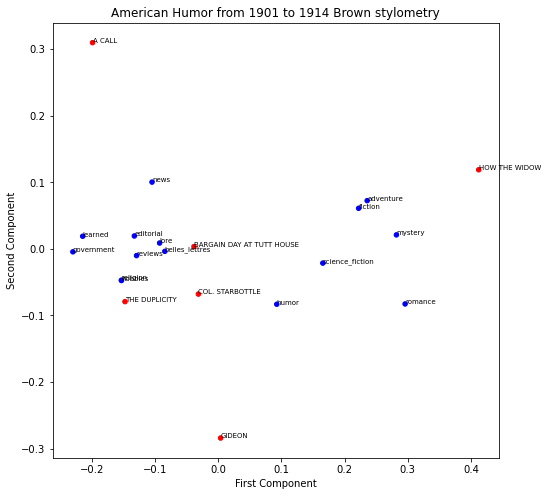

In [227]:
genrePredictor(humorCorpus)

As a further confirmation of the errors in the model, I selected a group of American humorous stories from a similar time period to the two previous corpora. Again, none of the stories are particularly close to the correct classification, humor. Only "Gideon" is listed as humor, but it is so far from the actual data point that the classification is likely insignificant. The genre predictor clearly should not be made using stylometric analysis as a basis for classification. A better model would focus on content, the other tenet of genre. Using content as a basis would require more tokenization and topic recognition and modeling rather than the method used in this project. 

Works Cited:

Kidd, David, and Emanuele Castano. “Different Stories: How Levels of Familiarity with Literary and Genre Fiction Relate to Mentalizing.” Psychology of Aesthetics, Creativity, and the Arts, vol. 11, no. 4, 2017, pp. 474–86. Crossref, https://doi.org/10.1037/aca0000069.

Piters, Ronald A. M. P., and Mia J. W. Stokmans. “Genre Categorization and Its Effect on Preference for Fiction Books.” Empirical Studies of the Arts, vol. 18, no. 2, July 2000, pp. 159–166, doi:10.2190/0VJF-Y04E-H5NU-VL5B.
